## On-Policy Prediction with Linear Approximation

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import matplotlib.pyplot as plt
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

The mountain car enviroment is represents a good candidate for value function approximation. This is because the state space is continuous. The state of the mountain car is given by its 2-dimensional co-ordinates. The lowest point is [-1.2 , -0.07], which the co-ordinates of top of the mountain are [0.6 ,0.07]. The goal of course, is to get the car to the top of the mountain.

[2017-03-10 02:14:05,467] Making new env: MountainCar-v0


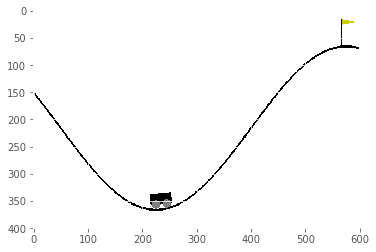

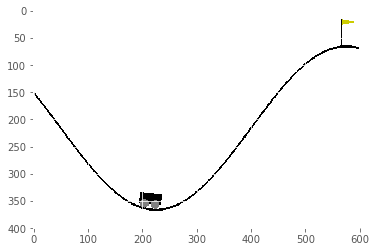

In [2]:
env = gym.envs.make("MountainCar-v0")

env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

[env.step(0) for x in range(10000)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.render(close=True)

There are several ways in which the states can be converted to features. I used Radial Basis Fuctions to featurize the states. 10000 random state samples are taken from the enviroment for training the RBF sampler.

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
def make_epsilon_greedy_policy(Theta, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        phi = featurize_state(observation)
        q_values = np.dot(Theta.T,phi)
        #q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def featurize_state(state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]

### semi-gradient TD

In [6]:
def sgTD(env, Theta, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            Theta, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
            #featurize present state and predict its value
            phi_s = featurize_state(state)
            q_values_s = np.dot(Theta.T,phi_s)
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            
            #if next_action is None:
                #action_probs = policy(state)
                #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            #else:
                #action = next_action
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            #q_values_next = estimator.predict(next_state)

            #featurize next state and predict its value
            phi_ns = featurize_state(next_state)
            q_values_next = np.dot(Theta.T,phi_ns)


            # Use this code for Q-Learning
            # Q-Value TD Target
            #td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            
            #next_action_probs = policy(next_state)
            #next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            
            #td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            #estimator.update(state, action, td_target)
            Theta[:,action] += 0.1*(reward + q_values_next[action] - q_values_s[action])*phi_s
            #Theta[:,action] += 0.1*(reward + np.max(q_values_next) - q_values_s[action])*phi_s
            
            state=next_state
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward),end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [7]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
Theta = np.random.normal(size=(400,env.action_space.n))
SGstats = sgTD(env, Theta, 1000, epsilon=0.0)

Step 199 @ Episode 1000/1000 (-200.0)

In [8]:
np.mean(SGstats.episode_rewards)

-187.827

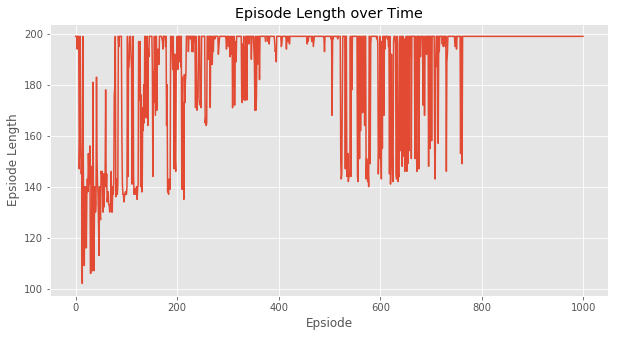

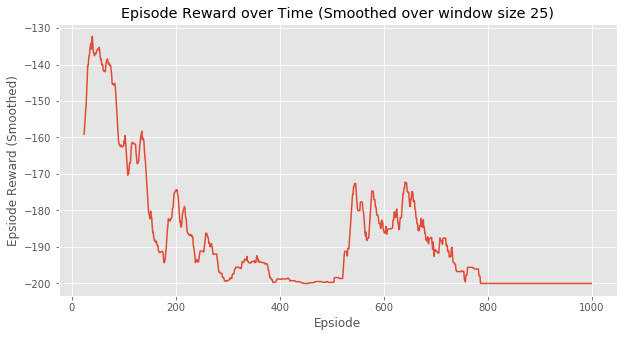

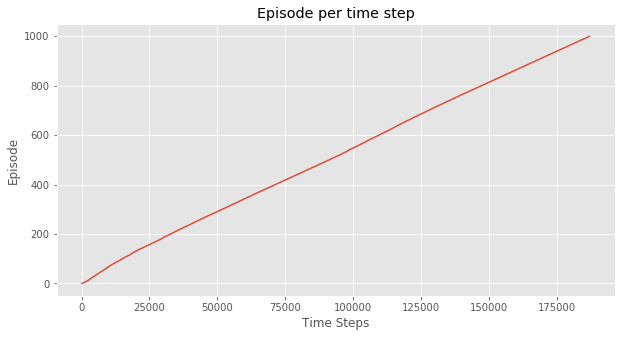

(<matplotlib.figure.Figure at 0x11b815780>,
 <matplotlib.figure.Figure at 0x11b7375c0>)

In [9]:
plotting.plot_episode_stats(SGstats, smoothing_window=25)

### semi-gradient TD with TDC

In [10]:
def TDC(env, Theta, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    w_s = np.zeros((400,))
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            Theta, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
            #featurize present state and predict its value
            phi_s = featurize_state(state)
            q_values_s = np.dot(Theta.T,phi_s)
            
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            #action_probs = policy(state)
            #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            #q_values_next = estimator.predict(next_state)

            #featurize next state and predict its value
            phi_ns = featurize_state(next_state)
            q_values_next = np.dot(Theta.T,phi_ns)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            #td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            #next_action_probs = policy(next_state)
            #next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            
            #td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            #estimator.update(state, action, td_target)
            #Theta[:,action] += 0.1*(reward + q_values_next[action] - q_values_s[action])*phi_s
            #td_error = reward + np.max(q_values_next) - q_values_s[action]
            
            td_error = reward + q_values_next[action] - q_values_s[action]
            
            Theta[:,action] += 0.1*td_error*phi_s - 0.1*np.dot(phi_s.T,w_s)*phi_ns
            w_s += 0.001*(td_error - np.dot(phi_s.T,w_s))*phi_s
            
            state=next_state
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward),end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [11]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
Theta = np.random.normal(size=(400,env.action_space.n))
stats = TDC(env, Theta, 1000, epsilon=0.0)

Step 190 @ Episode 1000/1000 (-141.0)

In [12]:
np.mean(stats.episode_rewards)

-153.01599999999999

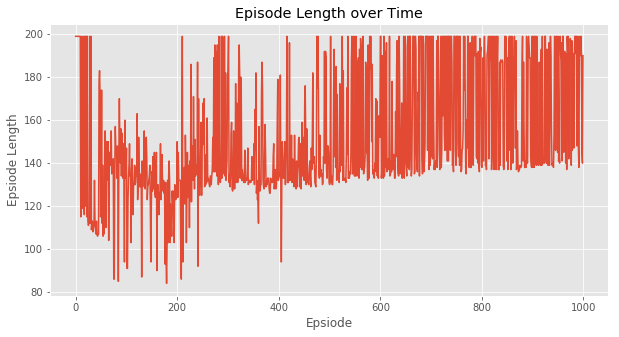

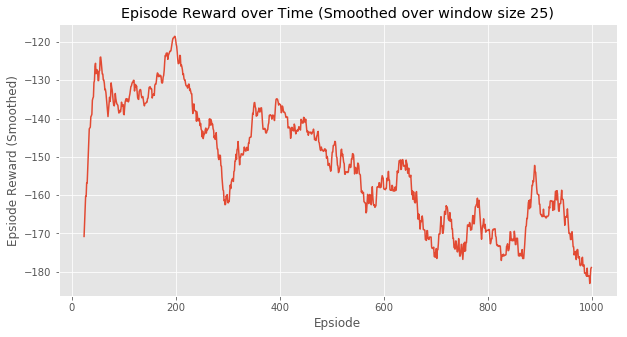

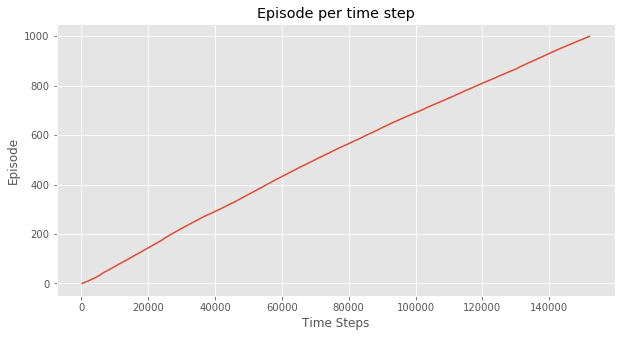

(<matplotlib.figure.Figure at 0x11ba6d780>,
 <matplotlib.figure.Figure at 0x11b3acfd0>)

In [13]:
#plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)